# Explorando la API de DBLP: Introducción y objetivos

## ¿Qué es DBLP?
DBLP es una base de datos bibliográfica en línea que proporciona información sobre publicaciones científicas, principalmente en el ámbito de la informática. Esta API permite acceder a datos estructurados sobre artículos, autores y conferencias, facilitando la búsqueda y el análisis de publicaciones académicas.

[Sitio web oficial de DBLP](https://dblp.org/)

---

- ¿Qué problemas puede enfrentar una API si no establece límites de consumo?
- ¿Cómo podría afectar esto a los usuarios finales o a los desarrolladores?

---



## ¿Cómo consumiríamos la API sin una especificación clara?
La API de DBLP no tiene una especificación formal sobre sus límites de consumo (*rate limits*) o cuotas. Sin embargo, en el siguiente [FAQ de DBLP](https://dblp.org/faq/Am+I+allowed+to+crawl+the+dblp+website.html), se indica que las solicitudes deben espaciarse cada 2 segundos. Seguimos sin un límite claro de solicitudes por minuto, pero tras realizar pruebas, se ha observado que el límite asumible es de **10 solicitudes por minuto**.

Vamos a probar un consumo regulado durante **1 minuto**, espaciando las solicitudes cada 3 segundos. Si el límite asumido de **10 solicitudes por minuto** es correcto, no deberíamos obtener errores 429.

In [1]:

import logging
import yaml
from Pricing4API.ancillary.yaml_serialization import PricingYamlHandler
from Pricing4API.ancillary.limit import Limit
from Pricing4API.ancillary.time_unit import TimeDuration, TimeUnit
from Pricing4API.main.new_plan import Plan
from Pricing4API.main.new_subscription import Subscription
PricingYamlHandler.load()

In [2]:
dblp_yaml = """
!Pricing
DBLP Pricing:
  metrics:
    name: requests
  plans:
    Free DBLP:
      cost: 0.0
      billing_cycle:
        value: 1
        unit: month
      unitary_rate: 
        /*:
          all:
            requests:
              period:
                value: 2
                unit: second
      quotas:
        /*:
          all:
            requests:
              - max: 15
                period:
                  value: 1
                  unit: minute
"""



In [3]:
pricing_DBLP = yaml.safe_load(dblp_yaml)

planes = pricing_DBLP.plans

for index, plan in enumerate(planes):
    print(plan.name," index: " , index)

Free DBLP  index:  0


In [4]:
free_dblp = planes[0] #type: Plan
dblp_subscription = Subscription(free_dblp, 'https://dblp.org/search/publ/api')

for limit in free_dblp.limits:
    print(limit.value, limit.duration)

2025-01-08 01:29:55 - root - INFO - Subscription to https://dblp.org/search/publ/api started at 1736296195.1335094


1 2 s
15 1 min


In [5]:
dblp_subscription.api_usage_simulator(TimeDuration(2, TimeUnit.SECOND))

2025-01-08 01:29:56 - root - INFO - Request (1) to https://dblp.org/search/publ/api exceeded the rate limit.
2025-01-08 01:29:56 - root - INFO - The Retry-After header is: 300 seconds
2025-01-08 01:29:56 - root - INFO - Waiting 2 s
2025-01-08 01:29:58 - root - INFO - Request (2) to https://dblp.org/search/publ/api exceeded the rate limit.
2025-01-08 01:29:58 - root - INFO - The Retry-After header is: 300 seconds


,Status Code,Response Time
0,429,0.162970
1,429,0.160624


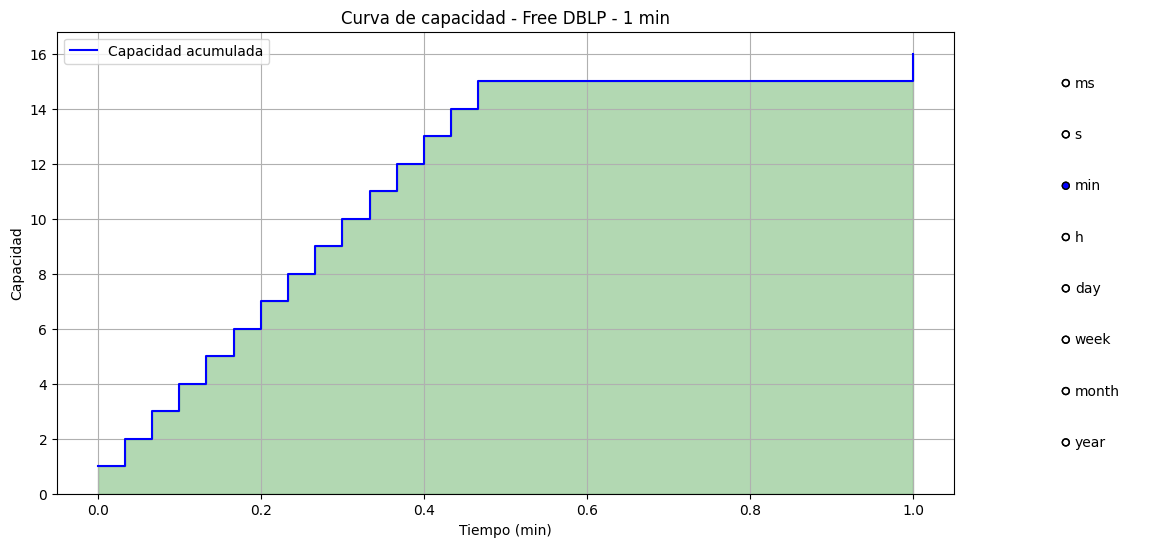

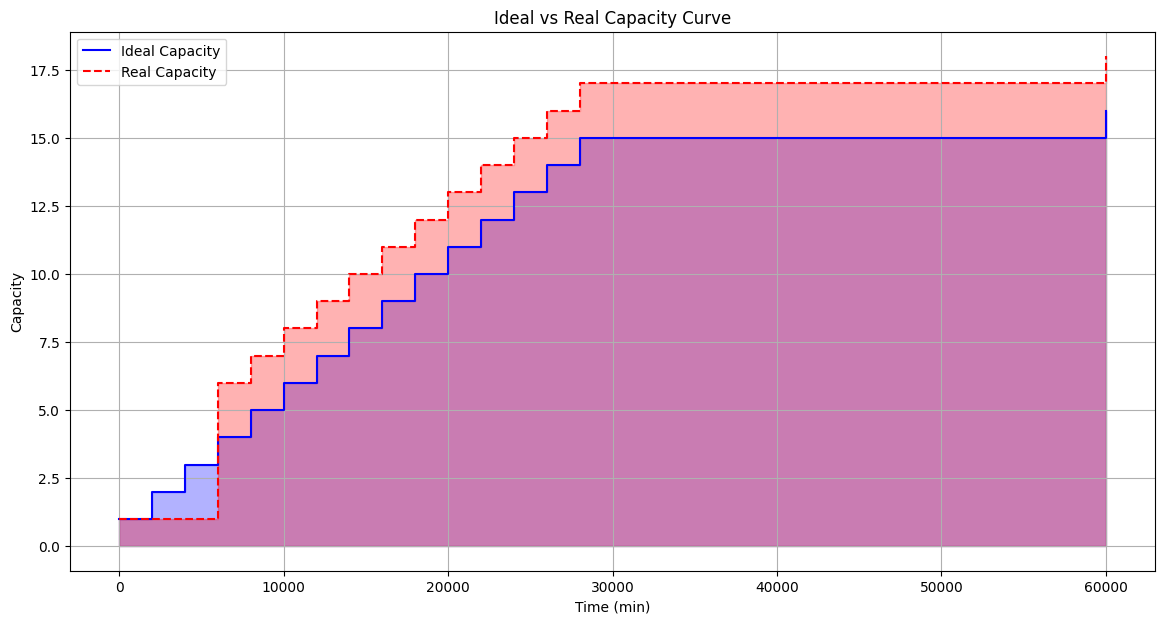

In [7]:
dblp_subscription.requests_429

dblp_subscription.show_real_capacity_and_ideal_capacity(TimeDuration(1, TimeUnit.MINUTE))



Definir la vigencia de un Pricing y la documentación actualizada son aspectos claves para garantizar un consumo adecuado de la API.

- Sin una especificación clara y actualizada, los desarrolladores deben deducir los límites mediante pruebas, lo que puede generar ineficiencias y errores.

## Regulado vs. No regulado

Cuando la suscripción está regulada, el simulador respeta los límites establecidos en el plan, asegurando que no aparezcan errores `429 Too Many Requests`.

Sin embargo, si marcamos la suscripción como no regulada, el simulador intentará realizar las solicitudes tan rápido como sea posible, ignorando los límites establecidos. En este caso, observaremos errores `429` en pocos segundos, ya que la API detectará el exceso de consumo.

In [ ]:
dblp_subscription.regulated(False)

dblp_subscription.api_usage_simulator(TimeDuration(30, TimeUnit.SECOND))

## ¿Y si tras un consumo no regulado, intento hacerlo de forma regulada justo después?

Como hemos observado en las pruebas anteriores, si intentamos consumir la API de forma no regulada, rápidamente nos encontraremos con errores `429 Too Many Requests`. Esto se debe a que estamos excediendo los límites de consumo permitidos por la API.

Ahora bien, si después de recibir un error `429` intentamos volver a consumir la API de forma regulada, nos encontraremos con que no es posible hacerlo inmediatamente. Esto se debe a que debemos esperar a que pase el tiempo especificado en la cabecera de "cooling down period" antes de poder realizar nuevas solicitudes de forma regulada.


In [ ]:
dblp_subscription.regulated(True)

dblp_subscription.api_usage_simulator(TimeDuration(30, TimeUnit.SECOND)) 

In [ ]:
# import time
# time.sleep(300)
# dblp_subscription.api_usage_simulator(TimeDuration(1, TimeUnit.MINUTE))


In [ ]:
dblp_yaml = """
!Pricing
DBLP Pricing:
  metrics:
    name: requests
  plans:
    Free DBLP:
      cost: 0.0
      billing_cycle:
        value: 1
        unit: month
      quotas:
        /*:
          all:
            requests:
              - max: 10
                period:
                  value: 1
                  unit: second
              - max: 100
                period:
                  value: 1
                  unit: minute
"""

pricing_DBLP = yaml.safe_load(dblp_yaml)

planes = pricing_DBLP.plans

for index, plan in enumerate(planes):
    print(plan.name," index: " , index)
    
free_dblp = planes[0]
dblp_subscription = Subscription(free_dblp, 'https://dblp.org/search/publ/api')
for limit in free_dblp.limits:
    print(limit.value, limit.duration)

In [ ]:
dblp_subscription.api_usage_simulator(TimeDuration(10, TimeUnit.SECOND))

In [ ]:
free_dblp.rate_value

---

## ¿Cuántas solicitudes puedes hacer?

Basándonos en lo que sabemos sobre la API, intenta responder a las siguientes preguntas. Usa los valores de **rate** y **cuota** para responder:

1. ¿Cuántas solicitudes se pueden hacer en:
   - 10 segundos?
   - 1 minuto?
   - 10 minutos?
   - 10 minutos y 30 segundos?

---

Para responder con precisión a estas preguntas, necesitamos una función que calcule el número máximo de solicitudes permitidas en un período \( t \), respetando tanto el **rate** como la **cuota** del plan.


### Ejercicio: Implementar capacity(t)

La función `capacity(t)` ya está implementada en la clase `Plan`. Vamos a probarla en distintos escenarios:

In [ ]:
time_simulation_10s = TimeDuration(10, TimeUnit.SECOND)
time_simulation_1m = TimeDuration(1, TimeUnit.MINUTE)
time_simulation_1min_9s = TimeDuration(1, TimeUnit.MINUTE) + TimeDuration(9, TimeUnit.SECOND)

capacity_10s = free_dblp.available_capacity(time_simulation_10s, len(free_dblp.limits) - 1)
capacity_1m = free_dblp.available_capacity(time_simulation_1m, len(free_dblp.limits) - 1)
capacity_1min_9s = free_dblp.available_capacity(time_simulation_1min_9s, len(free_dblp.limits) - 1)

print(f"Capacidad en 10 segundos: {capacity_10s}")
print(f"Capacidad en 1 minuto: {capacity_1m}")
print(f"Capacidad en 1 minuto y 9 segundos: {capacity_1min_9s}")

## ¿Cuánto tiempo necesitas para hacer X solicitudes?

Usando los límites de la API (rate y cuota), intenta calcular cuánto tiempo tomaría realizar las siguientes solicitudes. Piensa si el rate o la cuota influirán más en el resultado:

1. ¿Cuánto tiempo necesitas para realizar:
   - 10 solicitudes?
   - 20 solicitudes?
   - 100 solicitudes?

---

Para responder estas preguntas, necesitamos una función, que calcule el tiempo mínimo necesario para realizar un número dado de solicitudes, respetando tanto el **rate** como la **cuota** del plan.

### Ejercicio: min_time(capacity_goal)

La función `min_time(capacity_goal)` ya está implementada en la clase `Plan`. Vamos a probarla en distintos escenarios:

In [ ]:
# Tiempo necesario para realizar 10, 20 y 100 solicitudes
time_10_requests = plan_dblp.min_time(10)
time_20_requests = plan_dblp.min_time(20)
time_100_requests = plan_dblp.min_time(100)

print(f"Tiempo para 10 solicitudes: {time_10_requests}")
print(f"Tiempo para 20 solicitudes: {time_20_requests}")
print(f"Tiempo para 100 solicitudes: {time_100_requests}")